# 04 Forecasting
Notebook placeholder for forecasting experiments.

1. Data Preparation 

In [ ]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
from prophet.diagnostics import cross_validation, performance_metrics
import pickle

In [31]:
### Preparing the data for forecasting with Prophet###

# Load the cleaned dataset
df = pd.read_csv("../data/cleaned_data/cleaned_amazon_sales_dataset.csv")

# Convert 'order_date' to datetime format
df['order_date'] = pd.to_datetime(df['order_date'])

# Prepare the data for Prophet
prophet_df = df.groupby('order_date')['total_revenue'].sum().reset_index()
prophet_df.columns = ['ds', 'y']    # Prophet requires the columns to be named 'ds' for the date and 'y' for the value

print(prophet_df.head())


          ds         y
0 2022-01-01  47860.37
1 2022-01-02  35499.55
2 2022-01-03  40929.87
3 2022-01-04  34813.73
4 2022-01-05  38316.72


In the data, each row represents a sale. There can be more than one sale in a day. Prophet expects a single value (y) for each date (ds). Therefore, we calculated the total turnover for that day by using `.groupby('order_date').sum()`.

2. Fitting the Model

In [33]:
# Initialize the Prophet model (with yearly and weekly seasonality)
model = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)

# Fit the model to the data (this is where the actual forecasting happens)
model.fit(prophet_df)

# Create a DataFrame to hold predictions for the next 30 days
future = model.make_future_dataframe(periods=30)

# Generate the forecast
forecast = model.predict(future)

print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']])

15:37:28 - cmdstanpy - INFO - Chain [1] start processing
15:37:28 - cmdstanpy - INFO - Chain [1] done processing


            ds          yhat    yhat_lower    yhat_upper
0   2022-01-01  43473.231400  34293.552392  52595.056971
1   2022-01-02  44107.060077  35108.280241  52770.565268
2   2022-01-03  43652.923439  34926.305436  51877.069383
3   2022-01-04  44103.696321  35779.755553  53245.567318
4   2022-01-05  44583.203748  35463.992547  53733.848255
..         ...           ...           ...           ...
755 2024-01-26  48776.464447  40194.726120  57064.957227
756 2024-01-27  46654.039749  38346.251319  55453.132013
757 2024-01-28  46618.195407  38147.385265  55807.476510
758 2024-01-29  45493.902704  37174.659569  54544.129940
759 2024-01-30  45285.853375  36980.088770  54434.196805

[760 rows x 4 columns]


* **`ds` (Datestamp):** The specific date for which the forecast is generated.

* **`yhat` (Predicted Value):** The model’s main forecast for that date (e.g., estimated total revenue).

* **`yhat_lower`:** The lower bound of the prediction interval, representing a conservative estimate under uncertainty.

* **`yhat_upper`:** The upper bound of the prediction interval, representing a potential best-case outcome within the model’s confidence range.


3. Visualization

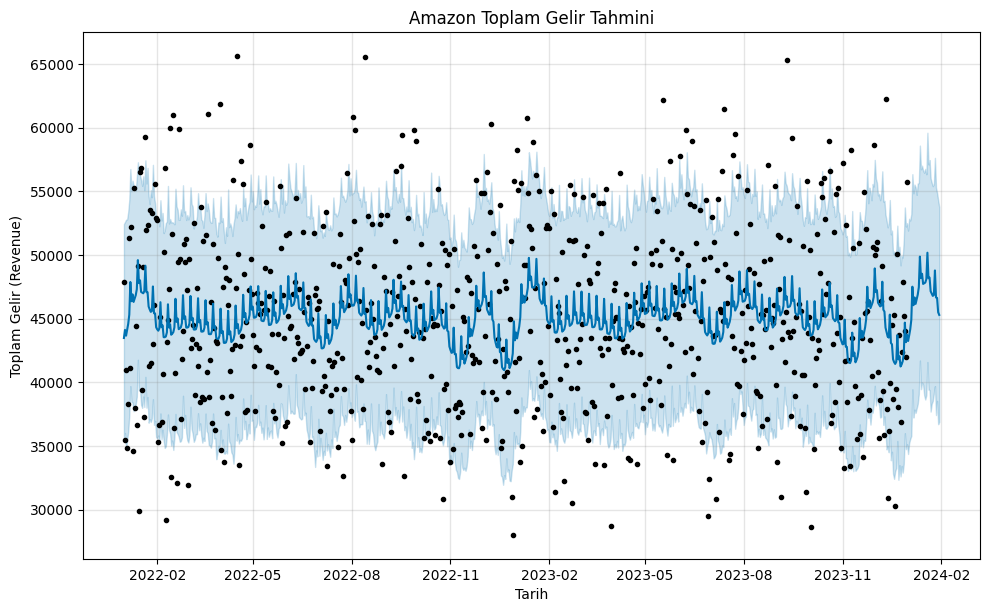

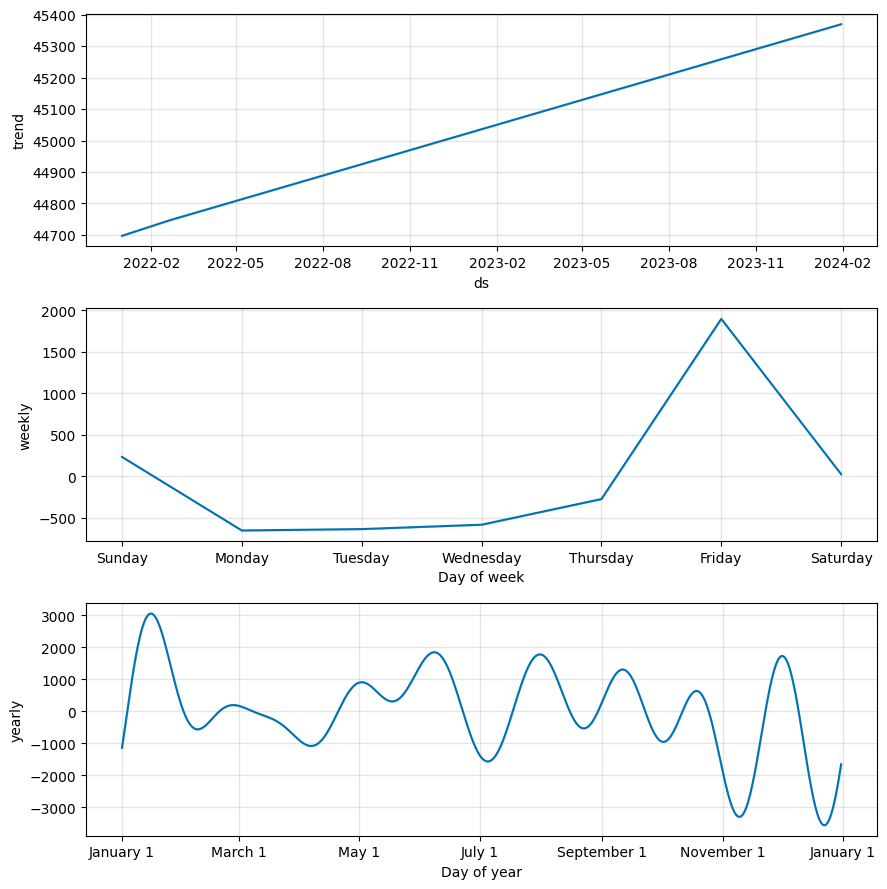

In [ ]:
# Plot the forecast
fig1 = model.plot(forecast)
plt.title("Amazon Toplam Gelir Tahmini")
plt.xlabel("Tarih")
plt.ylabel("Toplam Gelir (Revenue)")
plt.show()

# Plot the forecast components (trend, yearly seasonality, weekly seasonality)
fig2 = model.plot_components(forecast)
plt.show()


These graphs show the following:

1. Main Forecast

Black dots represent actual sales, the blue line shows the model’s fitted trend, and the shaded area indicates the confidence interval. Uncertainty increases in future predictions.

2. Trend

The overall trend is upward. Despite fluctuations, the store shows steady growth over time.

3. Weekly Seasonality

Sales peak on Fridays and are lowest on Mondays and Tuesdays, indicating stronger demand toward the weekend.

4. Yearly Seasonality

Significant spikes appear in early January and November (likely campaign-driven), with seasonal fluctuations throughout the year.

In [ ]:
# Perform cross-validation to evaluate the model's performance
df_cv = cross_validation(model, initial='540 days', period='31 days', horizon='90 days')

# Calculate performance metrics
df_p = performance_metrics(df_cv)

print(df_p[['horizon', 'mae', 'rmse', 'mape']].head())

  0%|          | 0/4 [00:00<?, ?it/s]02:29:41 - cmdstanpy - INFO - Chain [1] start processing
02:29:41 - cmdstanpy - INFO - Chain [1] done processing
02:29:41 - cmdstanpy - INFO - Chain [1] start processing
02:29:41 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 2/4 [00:00<00:00, 18.19it/s]02:29:41 - cmdstanpy - INFO - Chain [1] start processing
02:29:41 - cmdstanpy - INFO - Chain [1] done processing
02:29:41 - cmdstanpy - INFO - Chain [1] start processing
02:29:41 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 4/4 [00:00<00:00, 14.98it/s]


  horizon          mae         rmse      mape
0  9 days  5492.953298  7121.685824  0.128088
1 10 days  5152.809139  6731.456469  0.115014
2 11 days  5943.516043  7467.984659  0.129999
3 12 days  5592.797387  7215.154525  0.123378
4 13 days  6343.037641  8016.328797  0.134529


16:51:41 - cmdstanpy - INFO - Chain [1] start processing
16:51:42 - cmdstanpy - INFO - Chain [1] done processing


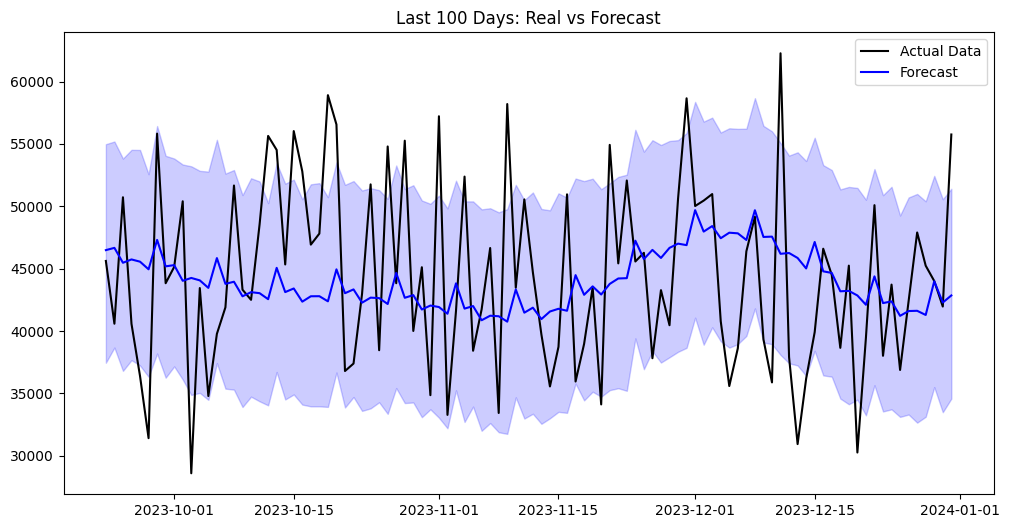

In [34]:
# 1. Divide the data (separate the last 100 days)
train_df = prophet_df[:-100] # Train except the last 100 days
test_df = prophet_df[-100:]  # Save the last 100 days for testing

# 2. Train the model using only train_df.
m_test = Prophet(yearly_seasonality=True, weekly_seasonality=True)
m_test.fit(train_df)

# 3. Create and predict the future for the next 100 days.
future_test = m_test.make_future_dataframe(periods=100)
forecast_test = m_test.predict(future_test)

# 4. Visualization: Compare predictions with actual data.
plt.figure(figsize=(12, 6))
plt.plot(test_df['ds'], test_df['y'], label='Actual Data', color='black')
plt.plot(forecast_test['ds'].tail(100), forecast_test['yhat'].tail(100), label='Forecast', color='blue')
plt.fill_between(forecast_test['ds'].tail(100), forecast_test['yhat_lower'].tail(100), forecast_test['yhat_upper'].tail(100), color='blue', alpha=0.2)
plt.legend()
plt.title("Last 100 Days: Real vs Forecast")
plt.show()

In [ ]:
import pickle

with open('prophet_model.pkl', 'wb') as f:
    pickle.dump(model, f)

print("Model 'prophet_model.pkl' olarak kaydedildi!")

Model 'prophet_model.pkl' olarak kaydedildi!
